### Choosing pickle files
- Using tensorboard determine the (1) test domain (2) best set of hparams
### PACS Dataset Information
- 66 $\rightarrow C_N=\{1,6\}, C_O=\{0,2,3,4,5\}$
- 33 $\rightarrow C_N=\{0,1,3,5,6\}, C_O=\{2,4\}$
### VLCS Dataset Information
- 66 $\rightarrow C_N=\{1\}, C_O=\{0,2,3,4\}$
- 33 $\rightarrow C_N=\{0,1,4\}, C_O=\{2,3\}$

In [1]:
import pandas as pd
from typing import List
import glob
import pathlib
import re
import matplotlib as mpl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from results import METHOD_NAME, ABLATIONS
plt.rcParams["font.family"] = "Times New Roman"

from IPython.core.debugger import set_trace

%matplotlib inline
%load_ext autoreload
%autoreload 2

#matplotlib.use('TkAgg')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

user='kimathikaai'

FILE_SAVE = f'/Users/{user}/scratch/saved/domainbed_results'

# get latex files
latex_files = []
val_latex_files = []
folders = [33, 66]
for folder in folders:
    latex_files.extend(glob.glob(f'/Users/{user}/scratch/saved/domainbed_results/{folder}/*.tex', recursive=True))
    #val_latex_files.extend(glob.glob(f'/Users/{user}/scratch/saved/domainbed_results/{folder}/*.tex-val', recursive=True))

    
print("Number of latex files: ", len(latex_files))
#print("Number of validation latex files: ", len(val_latex_files))
assert len(latex_files) == len(folders) * 6 * 6
#assert len(val_latex_files) == len(folders) * 6 * 6

# convert latex documents to a pandas dataframe
from results import scrape_latex
data = []
# scrape each latex file
for file in latex_files:
    #print('[info] processing: ', file)
    data.extend(scrape_latex(file))

# convert to pandas data frame
df = pd.DataFrame.from_dict(data).sort_values(by=["baseline", "algorithm"], ascending=False).reset_index(drop=True)

Number of latex files:  72


In [2]:
len(df.loc[df['algorithm'].isin([METHOD_NAME])])

216

In [3]:
data = df.loc[df['algorithm'].isin([METHOD_NAME])]
df.loc[df['algorithm'].isin([METHOD_NAME])]

,dataset,overlap,algorithm,selection_metric,evaluation_metric,selection_value,evaluation_value,selection_std,evaluation_std,baseline
4356,VLCS,33,FOND,nacc,oacc,None,51.3,None,1.8,0
4357,PACS,33,FOND,nacc,oacc,None,86.1,None,0.6,0
4358,OfficeHome,33,FOND,nacc,oacc,None,57.3,None,1.0,0
4359,VLCS,33,FOND,acc,vacc,None,49.9,None,0.8,0
4360,PACS,33,FOND,acc,vacc,None,61.2,None,0.3,0
4361,OfficeHome,33,FOND,acc,vacc,None,50.1,None,0.1,0
4362,VLCS,33,FOND,acc,nacc,None,44.2,None,1.5,0
4363,PACS,33,FOND,acc,nacc,None,35.5,None,0.3,0
4364,OfficeHome,33,FOND,acc,nacc,None,40.6,None,0.2,0
4365,VLCS,33,FOND,nacc,macc,None,49.3,None,0.9,0


In [4]:
len(data.loc[data['overlap'].isin(['66'])])

108

# Ablations
- Imposing fairnes (POXL) increases (nacc,nacc) and (acc,acc) than without (POXL-F) for (PACS, 33, 66)
- (POXL+B) is better than (POXL) for lower overlap (PACS, 33) but not for higher overlap
    - More difficult to impose fairness with less overlapping data
- Including alpha+beta is benefical for (acc, acc, PACS, 33, 66) (POXL-F-A vs POXL-F+B)
    - (nacc, nacc, PACS, 66) alpha+beta is more beneficial
    - (nacc, nacc, PACS, 33) alpha+beta is less beneficial

In [5]:
data = df.loc[(df['evaluation_metric'].isin(['nacc', 'macc']))&(df['selection_metric'].isin(['macc','nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome', 'VLCS']))&(df['overlap'].isin(['33', '66']))][df['algorithm'].isin(ABLATIONS)].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
pd.pivot_table(data=data, values=['evaluation_value', 'evaluation_std'], index=['selection_metric', 'evaluation_metric','algorithm'], columns=['dataset', 'overlap'], aggfunc=np.mean)

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_56886/544882138.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df.loc[(df['evaluation_metric'].isin(['nacc', 'macc']))&(df['selection_metric'].isin(['macc','nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome', 'VLCS']))&(df['overlap'].isin(['33', '66']))][df['algorithm'].isin(ABLATIONS)].sort_values(by='algorithm', ascending=True).reset_index(drop=True)


evaluation_std                 \
dataset                                          OfficeHome      PACS        
overlap                                                  33   66   33   66   
selection_metric evaluation_metric algorithm                                 
macc             macc              FOND                 0.1  0.2  0.3  1.1   
                                   FOND\F               0.6  0.3  0.3  0.3   
                                   FOND\FB              0.2  0.4  0.5  0.6   
                                   FOND\FBA             0.7  0.5  0.9  1.3   
                 nacc              FOND                 0.0  0.4  0.3  1.2   
                                   FOND\F               0.6  0.3  0.5  0.6   
                                   FOND\FB              0.4  0.9  0.5  0.5   
                                   FOND\FBA             0.5  0.7  1.3  1.6   
nacc             macc              FOND                 0.6  0.4  1.0  0.7   
                                   FOND\F               0.5  0.2  0.8  1.2   
                                   FOND\FB              0.4  0.6  0.4  0.7   
                                   FOND\FBA             0.6  0.1  0.8  0.3   
                 nacc              FOND                 0.3  0.4  1.2  0.6   
                                   FOND\F               0.6  0.6  0.5  1.4   
                                   FOND\FB              0.5  0.7  0.5  0.6   
                                   FOND\FBA             0.4  0.5  1.2  1.3   

                                                       evaluation_value        \
dataset                                      VLCS            OfficeHome         
overlap                                        33   66               33    66   
selection_metric evaluation_metric algorithm                                    
macc             macc              FOND       1.6  0.6             47.5  53.9   
                                   FOND\F     0.1  0.9             47.3  54.7   
                                   FOND\FB    0.8  0.4             47.6  55.3   
                                   FOND\FBA   1.1  0.3             47.6  54.3   
                 nacc              FOND       1.8  1.9             40.3  40.6   
                                   FOND\F     1.1  1.7             40.2  39.9   
                                   FOND\FB    1.6  1.2             40.5  40.3   
                                   FOND\FBA   0.9  2.8             40.9  39.3   
nacc             macc              FOND       0.9  5.0             46.9  52.6   
                                   FOND\F     0.5  2.4             47.5  53.9   
                                   FOND\FB    1.1  1.2             47.8  55.3   
                                   FOND\FBA   1.2  1.1             47.9  53.5   
                 nacc              FOND       0.4  3.5             40.3  40.6   
                                   FOND\F     1.0  6.0             40.6  40.8   
                                   FOND\FB    0.2  2.3             41.0  41.7   
                                   FOND\FBA   1.0  2.8             41.0  39.1   

                                                                      
dataset                                       PACS        VLCS        
overlap                                         33    66    33    66  
selection_metric evaluation_metric algorithm                          
macc             macc              FOND       50.2  58.0  51.6  52.5  
                                   FOND\F     49.0  59.1  48.7  52.0  
                                   FOND\FB    48.9  58.3  49.8  50.6  
                                   FOND\FBA   48.6  58.9  51.3  51.7  
                 nacc              FOND       35.3  11.6  47.9  42.2  
                                   FOND\F     34.1  14.8  45.1  34.9  
                                   FOND\FB    34.2  13.0  45.9  33.4  
                                   FOND\FBA   33.7  13.1  47.1  34.0  
nacc       

## Pivot Table

In [6]:
data = df.loc[(df['evaluation_metric'].isin(['nacc']))&(df['selection_metric'].isin(['nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome', 'VLCS']))&(df['overlap'].isin(['66', '33']))][df['algorithm'].isin(ABLATIONS)].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
pd.pivot_table(data=data, values=['evaluation_value', 'evaluation_std'], index=['selection_metric', 'evaluation_metric','algorithm'], columns=['overlap', 'dataset'], aggfunc=np.mean)

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_56886/2782757541.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df.loc[(df['evaluation_metric'].isin(['nacc']))&(df['selection_metric'].isin(['nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome', 'VLCS']))&(df['overlap'].isin(['66', '33']))][df['algorithm'].isin(ABLATIONS)].sort_values(by='algorithm', ascending=True).reset_index(drop=True)


evaluation_std            \
overlap                                                  33             
dataset                                          OfficeHome PACS VLCS   
selection_metric evaluation_metric algorithm                            
nacc             nacc              FOND                 0.3  1.2  0.4   
                                   FOND\F               0.6  0.5  1.0   
                                   FOND\FB              0.5  0.5  0.2   
                                   FOND\FBA             0.4  1.2  1.0   

                                                                   \
overlap                                              66             
dataset                                      OfficeHome PACS VLCS   
selection_metric evaluation_metric algorithm                        
nacc             nacc              FOND             0.4  0.6  3.5   
                                   FOND\F           0.6  1.4  6.0   
                                   FOND\FB          0.7  0.6  2.3   
                                   FOND\FBA         0.5  1.3  2.8   

                                             evaluation_value              \
overlap                                                    33               
dataset                                            OfficeHome  PACS  VLCS   
selection_metric evaluation_metric algorithm                                
nacc             nacc              FOND                  40.3  35.3  48.0   
                                   FOND\F                40.6  35.3  48.5   
                                   FOND\FB               41.0  33.2  50.0   
                                   FOND\FBA              41.0  35.4  46.6   

                                                                     
overlap                                              66              
dataset                                      OfficeHome  PACS  VLCS  
selection_metric evaluation_metric algorithm                         
nacc             nacc              FOND            40.6  19.1  72.1  
                                   FOND\F          40.8  17.5  51.7  
                                   FOND\FB         41.7  15.4  44.0  
                                   FOND\FBA        39.1  17.3  51.3

In [7]:
data = df.loc[(df['evaluation_metric'].isin(['nacc']))&(df['selection_metric'].isin(['nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome', 'VLCS']))&(df['overlap'].isin(['66', '33']))][df['algorithm'].isin(ABLATIONS)].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
pd.pivot_table(data=data, values=['evaluation_value', 'evaluation_std'], index=['selection_metric', 'evaluation_metric','algorithm'], columns=['overlap'], aggfunc=np.mean)

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_56886/3038905498.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df.loc[(df['evaluation_metric'].isin(['nacc']))&(df['selection_metric'].isin(['nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome', 'VLCS']))&(df['overlap'].isin(['66', '33']))][df['algorithm'].isin(ABLATIONS)].sort_values(by='algorithm', ascending=True).reset_index(drop=True)


evaluation_std            \
overlap                                                  33        66   
selection_metric evaluation_metric algorithm                            
nacc             nacc              FOND            0.633333  1.500000   
                                   FOND\F          0.700000  2.666667   
                                   FOND\FB         0.400000  1.200000   
                                   FOND\FBA        0.866667  1.533333   

                                             evaluation_value             
overlap                                                    33         66  
selection_metric evaluation_metric algorithm                              
nacc             nacc              FOND             41.200000  43.933333  
                                   FOND\F           41.466667  36.666667  
                                   FOND\FB          41.400000  33.700000  
                                   FOND\FBA         41.000000  35.900000

In [8]:
data = df.loc[(df['evaluation_metric'].isin(['nacc']))&(df['selection_metric'].isin(['nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome', 'VLCS']))&(df['overlap'].isin(['33', '66']))][df['algorithm'].isin(ABLATIONS)].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
pd.pivot_table(data=data, values=['evaluation_value', 'evaluation_std'], index=['selection_metric', 'evaluation_metric','algorithm'], columns=['dataset'], aggfunc=np.mean)

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_56886/1848276293.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df.loc[(df['evaluation_metric'].isin(['nacc']))&(df['selection_metric'].isin(['nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome', 'VLCS']))&(df['overlap'].isin(['33', '66']))][df['algorithm'].isin(ABLATIONS)].sort_values(by='algorithm', ascending=True).reset_index(drop=True)


evaluation_std              \
dataset                                          OfficeHome  PACS  VLCS   
selection_metric evaluation_metric algorithm                              
nacc             nacc              FOND                0.35  0.90  1.95   
                                   FOND\F              0.60  0.95  3.50   
                                   FOND\FB             0.60  0.55  1.25   
                                   FOND\FBA            0.45  1.25  1.90   

                                             evaluation_value                
dataset                                            OfficeHome   PACS   VLCS  
selection_metric evaluation_metric algorithm                                 
nacc             nacc              FOND                 40.45  27.20  60.05  
                                   FOND\F               40.70  26.40  50.10  
                                   FOND\FB              41.35  24.30  47.00  
                                   FOND\FBA             40.05  26.35  48.95

In [9]:
data = df.loc[(df['evaluation_metric'].isin(['nacc']))&(df['selection_metric'].isin(['nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome', 'VLCS']))&(df['overlap'].isin(['33', '66']))][df['algorithm'].isin(ABLATIONS)].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
pd.pivot_table(data=data, values=['evaluation_value', 'evaluation_std'], index=['selection_metric', 'evaluation_metric','algorithm'], aggfunc=np.mean)

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_56886/1236784846.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df.loc[(df['evaluation_metric'].isin(['nacc']))&(df['selection_metric'].isin(['nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome', 'VLCS']))&(df['overlap'].isin(['33', '66']))][df['algorithm'].isin(ABLATIONS)].sort_values(by='algorithm', ascending=True).reset_index(drop=True)


evaluation_std  evaluation_value
selection_metric evaluation_metric algorithm                                  
nacc             nacc              FOND             1.066667         42.566667
                                   FOND\F           1.683333         39.066667
                                   FOND\FB          0.800000         37.550000
                                   FOND\FBA         1.200000         38.450000

# Relationships Between Metrics
- Determine what `selection_metric` is a good indicator for a specific `evaluation_metric`

In [10]:
df.loc[(df['selection_metric'].isin(['nacc', 'acc'])) &(df['evaluation_metric'].isin(['nacc','acc']))
#].groupby(['dataset', 'overlap', 'selection_metric', 'evaluation_metric']).mean(numeric_only=True)
].groupby(['dataset','selection_metric', 'evaluation_metric']).mean(numeric_only=True)

evaluation_value  \
dataset    selection_metric evaluation_metric                     
OfficeHome acc              acc                       50.056410   
                            nacc                      39.407692   
           nacc             acc                       49.700000   
                            nacc                      39.630769   
PACS       acc              acc                       50.300000   
                            nacc                      23.730435   
           nacc             acc                       50.232609   
                            nacc                      25.930435   
VLCS       acc              acc                       47.069048   
                            nacc                      40.500000   
           nacc             acc                       44.526190   
                            nacc                      51.616667   

                                               evaluation_std  baseline  
dataset    selection_metric evaluation_metric                            
OfficeHome acc              acc                      0.361538  0.410256  
                            nacc                     0.435897  0.410256  
           nacc             acc                      0.387179  0.410256  
                            nacc                     0.412821  0.410256  
PACS       acc              acc                      0.539130  0.347826  
                            nacc                     0.843478  0.347826  
           nacc             acc                      0.717391  0.347826  
                            nacc                     1.119565  0.347826  
VLCS       acc              acc                      0.826190  0.380952  
                            nacc                     1.388095  0.380952  
           nacc             acc                      1.416667  0.380952  
                            nacc                     2.402381  0.380952

### What is  the AVERAGE performance ACROSS DATASETS for each overlap and metric?

In [11]:
df.groupby(['overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_56886/2889167385.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()


evaluation_value  \
overlap selection_metric evaluation_metric algorithm                               
33      acc              acc               ARM                         45.800000   
                                           CAD                         44.433333   
                                           CORAL                       47.466667   
                                           CausIRL_MMD                 45.900000   
                                           ERM                         46.400000   
                                           FOND                        47.300000   
                                           FOND\F                      47.133333   
                                           FOND\FB                     47.033333   
                                           FOND\FBA                    46.966667   
                                           Intra                       46.833333   
                                           Intra_XDom                  47.500000   
                                           MLDG                        45.733333   
                                           SelfReg                     46.066667   
                                           Transfer                    45.700000   
                                           XDomBatch                   46.100000   
                                           XDomBetaErrorMLDG           46.566667   
                                           XDomBetaErrorMLDGV2         46.266667   
                                           XDomBetaErrorMLDGV3         46.666667   
                                           XDomBetaMLDG                47.433333   
                                           XDomBetaMLDGV2              45.800000   
                                           XDomError                   46.666667   
                                           XDomMLDG                    47.200000   
                                           XMLDG                       47.333333   
                         f1                ARM                         41.266667   
                                           CAD                         39.433333   
                                           CORAL                       42.700000   
                                           CausIRL_MMD                 41.133333   
                                           ERM                         41.466667   
                                           FOND                        42.933333   
                                           FOND\F                      42.533333   
                                           FOND\FB                     42.933333   
                                           FOND\FBA                    42.533333   
                                           Intra                       42.133333   
                                           Intra_XDom                  41.800000   
                                           MLDG                        41.566667   
                                           SelfReg                     41.166667   
                                           Transfer                    41.133333   
                                           XDomBatch                   39.900000   
                                           XDomBetaErrorMLDG           42.066667   
                                           XDomBetaErrorMLDGV2         41.933333   
                                           XDomBetaErrorMLDGV3         42.300000   
                                           XDomBetaMLDG                42.466667   
                                           XDomBetaMLDGV2              40.800000   
                                           XDomError                   42.066667   
                                           XDomMLDG                    42.600000   
                                           XMLDG                       43.233333   
                         macc   

### What is the performance across dataset, overlap and metric?

# 1| Baselines

In [12]:
from results import BASELINES, METHODS
df_pivot = df.loc[
    (df['dataset'].isin(['OfficeHome', 'PACS', 'VLCS'])) &
    (df['overlap'].isin(['33', '66'])) &
    (df['evaluation_metric'].isin(['nacc'])) &
    (df['selection_metric'].isin(['nacc'])) &
    # (df['algorithm'].isin(BASELINES + METHODS))
    (df['algorithm'].isin(['CausIRL_MMD']))
].sort_values(by=["baseline", "algorithm"], ascending=False).reset_index(drop=True)

pd.pivot(data=df_pivot, values=['evaluation_value', 'evaluation_std'], index=['selection_metric', 'evaluation_metric','algorithm'], columns=['dataset', 'overlap'])

evaluation_value        \
dataset                                                    VLCS  PACS   
overlap                                                      33    33   
selection_metric evaluation_metric algorithm                            
nacc             nacc              CausIRL_MMD             47.2  37.7   

                                                                       \
dataset                                        OfficeHome  VLCS  PACS   
overlap                                                33    66    66   
selection_metric evaluation_metric algorithm                            
nacc             nacc              CausIRL_MMD       38.0  57.5  18.0   

                                                          evaluation_std       \
dataset                                        OfficeHome           VLCS PACS   
overlap                                                66             33   33   
selection_metric evaluation_metric algorithm                                    
nacc             nacc              CausIRL_MMD       38.5            1.0  1.3   

                                                                                
dataset                                        OfficeHome VLCS PACS OfficeHome  
overlap                                                33   66   66         66  
selection_metric evaluation_metric algorithm                                    
nacc             nacc              CausIRL_MMD        0.1  2.0  2.5        0.2

## 1.1| Overall Average Across Dataset and Overlap

In [13]:
df_pivot.groupby(['selection_metric', 'evaluation_metric', 'algorithm']).mean(numeric_only=True)

,,,evaluation_value,evaluation_std,baseline
selection_metric,evaluation_metric,algorithm,,,
nacc,nacc,CausIRL_MMD,39.483333,1.183333,1.0


## 1.2| Average Per Dataset

In [14]:
df_pivot.groupby(['selection_metric', 'evaluation_metric','algorithm', 'dataset']).mean(numeric_only=True)

evaluation_value  \
selection_metric evaluation_metric algorithm   dataset                        
nacc             nacc              CausIRL_MMD OfficeHome             38.25   
                                               PACS                   27.85   
                                               VLCS                   52.35   

                                                           evaluation_std  \
selection_metric evaluation_metric algorithm   dataset                      
nacc             nacc              CausIRL_MMD OfficeHome            0.15   
                                               PACS                  1.90   
                                               VLCS                  1.50   

                                                           baseline  
selection_metric evaluation_metric algorithm   dataset               
nacc             nacc              CausIRL_MMD OfficeHome       1.0  
                                               PACS             1.0  
                                               VLCS             1.0

## 1.3| Average Per Overlap

In [15]:
df_pivot.groupby(['selection_metric', 'evaluation_metric', 'algorithm', 'overlap']).mean(numeric_only=True)

evaluation_value  \
selection_metric evaluation_metric algorithm   overlap                     
nacc             nacc              CausIRL_MMD 33              40.966667   
                                               66              38.000000   

                                                        evaluation_std  \
selection_metric evaluation_metric algorithm   overlap                   
nacc             nacc              CausIRL_MMD 33             0.800000   
                                               66             1.566667   

                                                        baseline  
selection_metric evaluation_metric algorithm   overlap            
nacc             nacc              CausIRL_MMD 33            1.0  
                                               66            1.0

### What is the difference between "oacc" and "noacc"?

In [16]:
cols = ['dataset', 'overlap', 'selection_metric', 'evaluation_metric', 'algorithm']

# nacc DNE in full overlap and oacc DNE in none overlap
data = df.loc[(
    (df['overlap'] == '33') | (df['overlap'] == '66') | 
    (df['overlap'] == 'mid') | (df['overlap'] == 'low')
)]

cols_a = ['dataset', 'algorithm', 'overlap', 'selection_metric', 'evaluation_value']
df_oacc = data[data['evaluation_metric'] == 'oacc'][cols_a].sort_values(
    by=cols_a, ascending=True).reset_index(drop=True)
df_nacc = data[data['evaluation_metric'] == 'nacc'][cols_a].sort_values(
    by=cols_a, ascending=True).reset_index(drop=True)

assert len(df_nacc) == len(df_oacc)
df_oacc['oacc-nacc'] = df_oacc['evaluation_value'] - df_nacc['evaluation_value']
data = df_oacc[['dataset', 'algorithm', 'overlap', 'selection_metric', 'oacc-nacc']]
a = data.groupby(['dataset', 'overlap', 'selection_metric','algorithm', 'oacc-nacc']).mean()

### What is the top performing algorithm for each dataset, overlap, and metric?
- For OfficeHome (33&66) the non-overlapping accuracy is highest for (XDom, Intra and SupCon approaches) consistently
- In general XDom shines the most with the availability of overlapping classes to benefit the non-overlapping classes (having a memory queue for under represented samples would help)
    - However we can also reduce the scope of the problem by focusing on 50%-75% overlap cases and/or performing random class selection
- (PACS 66) (selec, eval)
    - (acc,acc) XDom, XDomBatch, XDomError
    - (acc,f1) XDom, XDomError, XDomBatch
    - (acc,nacc) Transfer with 0.2% difference from XDomError with 0.7% difference from XDom

In [17]:
cols = ['dataset', 'overlap', 'selection_metric', 'evaluation_metric', 'algorithm']
base_group = df.loc[
#         (df['algorithm'] != 'XDom') &
#         (df['algorithm'] != 'Intra') &
#         (df['algorithm'] != 'SupCon') &
#         (df['algorithm'] != 'Intra_XDom') &
#         ((df['dataset'] == 'PACS') | (df['dataset'] == 'OfficeHome'))  &
#         (df['overlap'] == 66) &
        (df['algorithm'] != 'XDomBatch')
    ].groupby(cols)
base_group.mean().loc[
    base_group.mean().groupby(cols[:-1])['evaluation_value'].idxmax()
]

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_56886/3777563572.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_group.mean().loc[
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_56886/3777563572.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_group.mean().groupby(cols[:-1])['evaluation_value'].idxmax()


evaluation_value  \
dataset    overlap selection_metric evaluation_metric algorithm                               
OfficeHome 33      acc              acc               CORAL                            50.1   
                                    f1                CORAL                            46.7   
                                    macc              CORAL                            49.0   
                                    nacc              FOND\FBA                         41.7   
                                    oacc              CORAL                            61.7   
                                    vacc              CORAL                            51.4   
                   f1               acc               CORAL                            50.3   
                                    f1                XMLDG                            46.8   
                                    macc              CORAL                            49.0   
                                    nacc              XMLDG                            41.8   
                                    oacc              CORAL                            62.0   
                                    vacc              CORAL                            51.4   
                   macc             acc               CORAL                            50.2   
                                    f1                CORAL                            46.4   
                                    macc              CORAL                            48.9   
                                    nacc              FOND\FBA                         40.9   
                                    oacc              CORAL                            61.7   
                                    vacc              CORAL                            51.3   
                   nacc             acc               CORAL                            49.9   
                                    f1                CORAL                            46.2   
                                    macc              CORAL                            48.7   
                                    nacc              FOND\FB                          41.0   
                                    oacc              CORAL                            61.5   
                                    vacc              CORAL                            51.1   
                   oacc             acc               CORAL                            50.1   
                                    f1                CORAL                            46.4   
                                    macc              CORAL                            48.6   
                                    nacc              Intra                            40.7   
                                    oacc              CORAL                            61.8   
                                    vacc              CORAL                            51.1   
                   vacc             acc               CORAL                            50.2   
                                    f1                CORAL                            46.5   
                                    macc              CORAL                            48.9   
                                    nacc              CORAL                            40.8   
                                    oacc              CORAL                            61.9   
                                    vacc              CORAL                            51.3   
           66      acc              acc               FOND\FB                          53.7   
                                    f1                FOND\FB                          49.9   
                                    macc              CORAL                            55.6   
                                    nacc              FOND\FB                          40.8   
                                    oacc              CORAL                          

In [18]:
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import itertools

def plot_results(df, selec_metric, eval_metric, overlap_list, dataset_list):
    
    my_cmap = plt.get_cmap("viridis")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    fig, ax = plt.subplots(
        nrows = len(dataset_list),
        ncols = len(overlap_list),
        figsize=(10,10),
        #figsize=(8,5),
        sharey=False)
    
    if len(dataset_list) == 1:
        ax = [ax]

    for i, dataset in enumerate(dataset_list):
        for j, overlap in enumerate(overlap_list):
            data = df.loc[
                (df['dataset'] == dataset) &
                (df['selection_metric'] == selec_metric) &
                (df['evaluation_metric'] == eval_metric) &
                (df['overlap'] == overlap)
            ].sort_values(by=['algorithm'], ascending=True)
            
            ax[i][j].bar(
                data.algorithm, 
                data.evaluation_value, 
                color=my_cmap(rescale(data.evaluation_value)),
                width=0.6
            )

            #plot_data = df_group.mean()['evaluation_value']
            #max_algo = plot_data.idxmax()
            #print(plot_data)

            #plot_data.plot(ax=ax[i][j], kind="bar")
            ax[i][j].set_title(f"{dataset}-{overlap}")
            #ax[i][j].set_yticks(np.arange(20,60,5))
            ax[i][j].yaxis.set_minor_locator(AutoMinorLocator(2))
            ax[i][j].get_yaxis().set_major_locator(MaxNLocator(integer=True))
            ax[i][j].set_ylim(
                min(data.evaluation_value) - 3,
                max(data.evaluation_value) + 3)
            #ax[i][j].set_ylim(40, 60)
            ax[i][j].grid(axis="y", which="both")
            ax[i][j].tick_params(axis='x', labelrotation=90)
            # ax[i][j].legend()
    
    fig.suptitle(f"(s,e) = ({selec_metric},{eval_metric})")
    fig.tight_layout(pad=1.0, h_pad=2.0)
    return fig

## Plot baselines performance across different overlaps and datasets
- XDomBeta > XDom for PACS (nacc,nacc) & (acc,acc) & (f1,f1)
- XMLDG > MLDG for OfficeHome 66 across all s=e settings

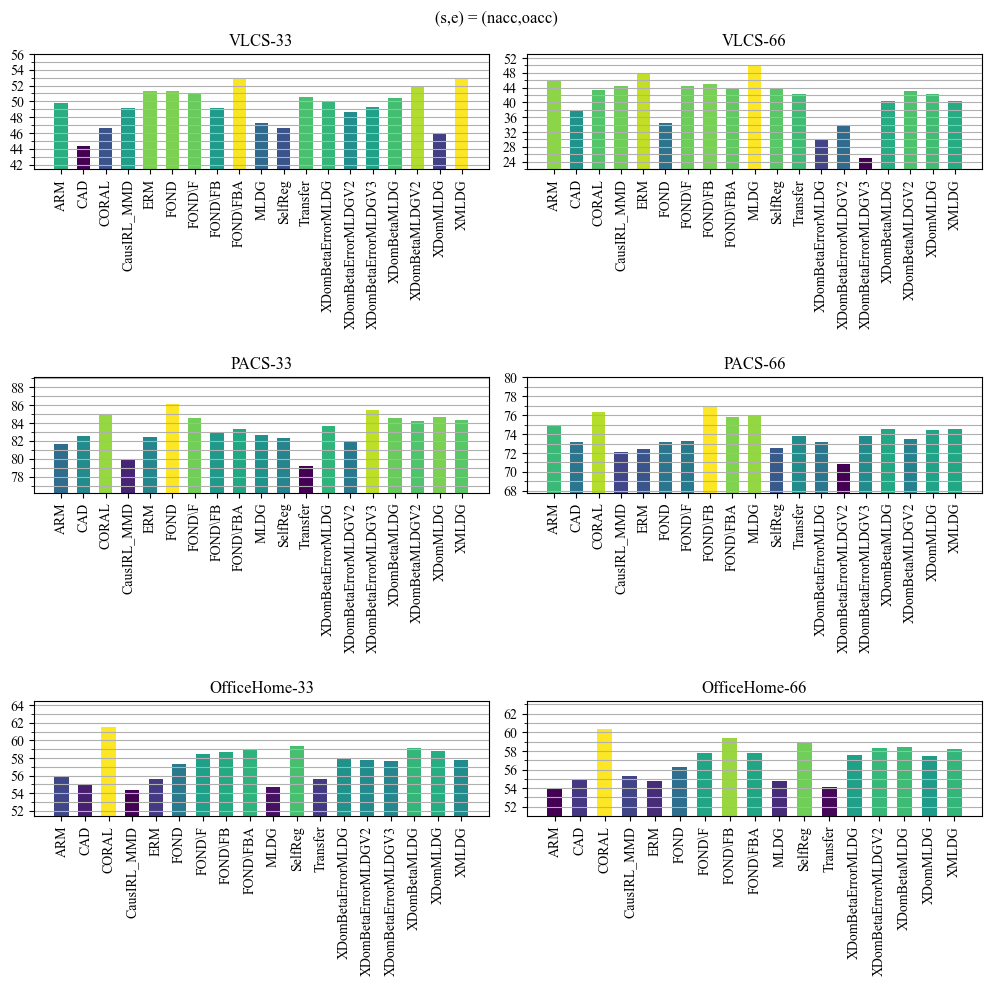

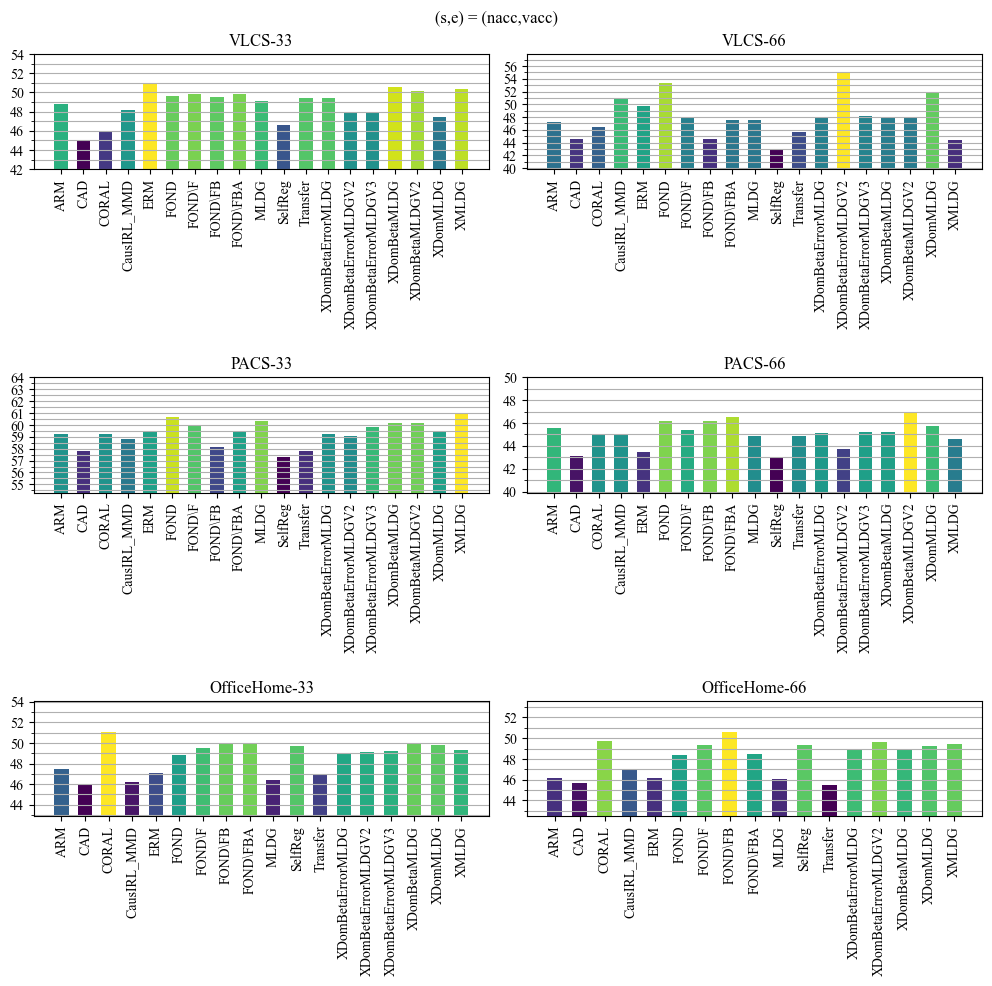

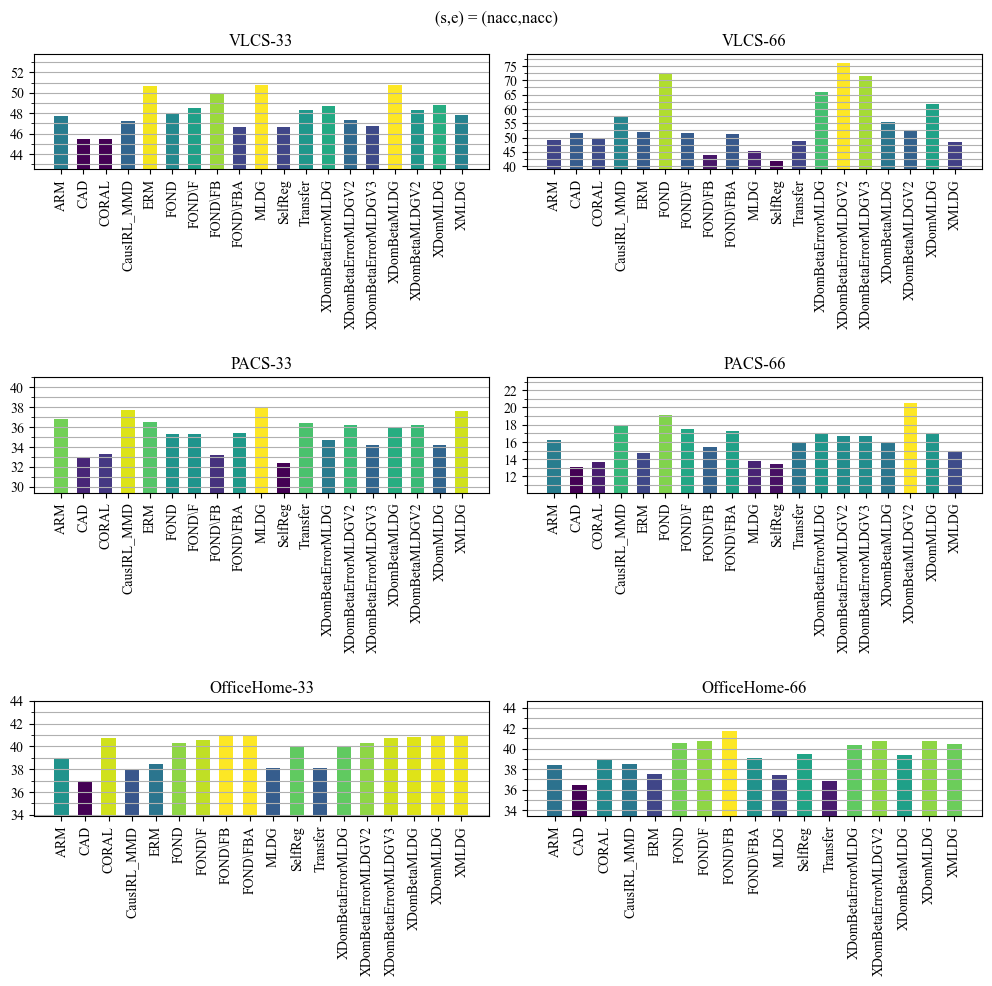

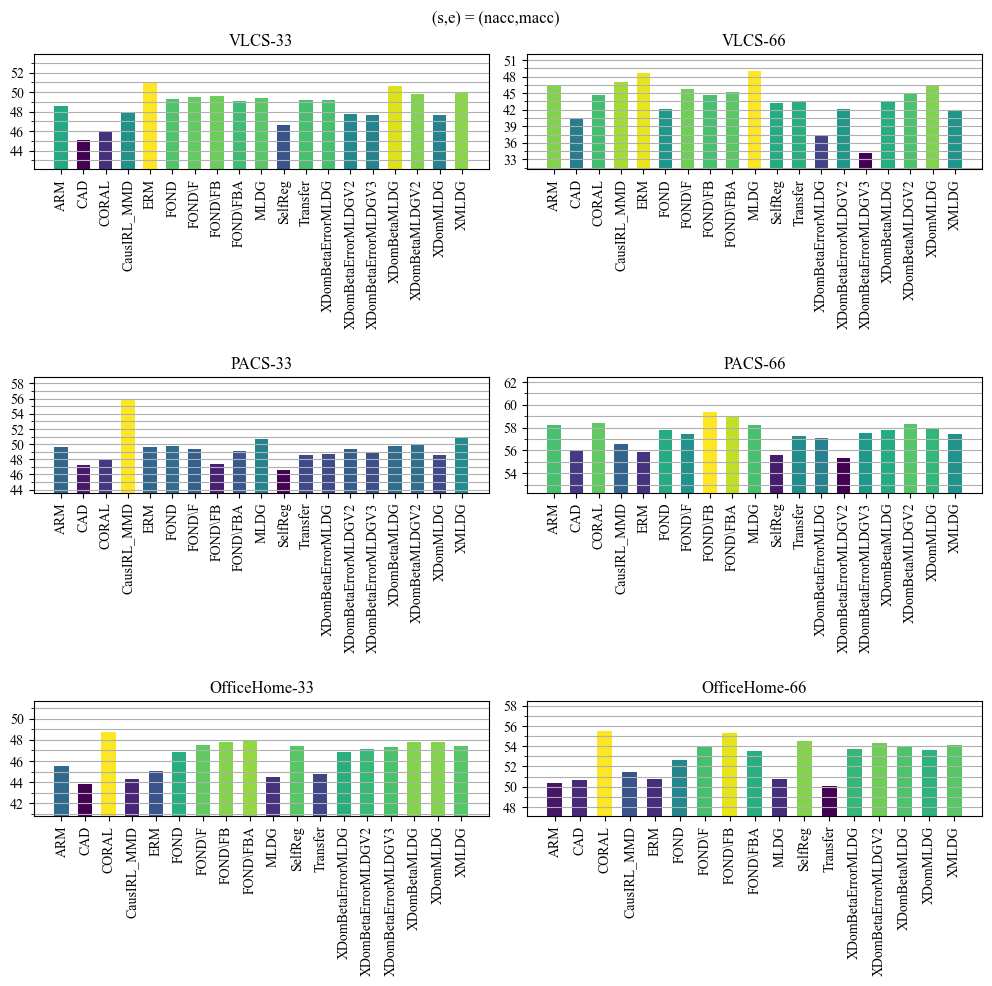

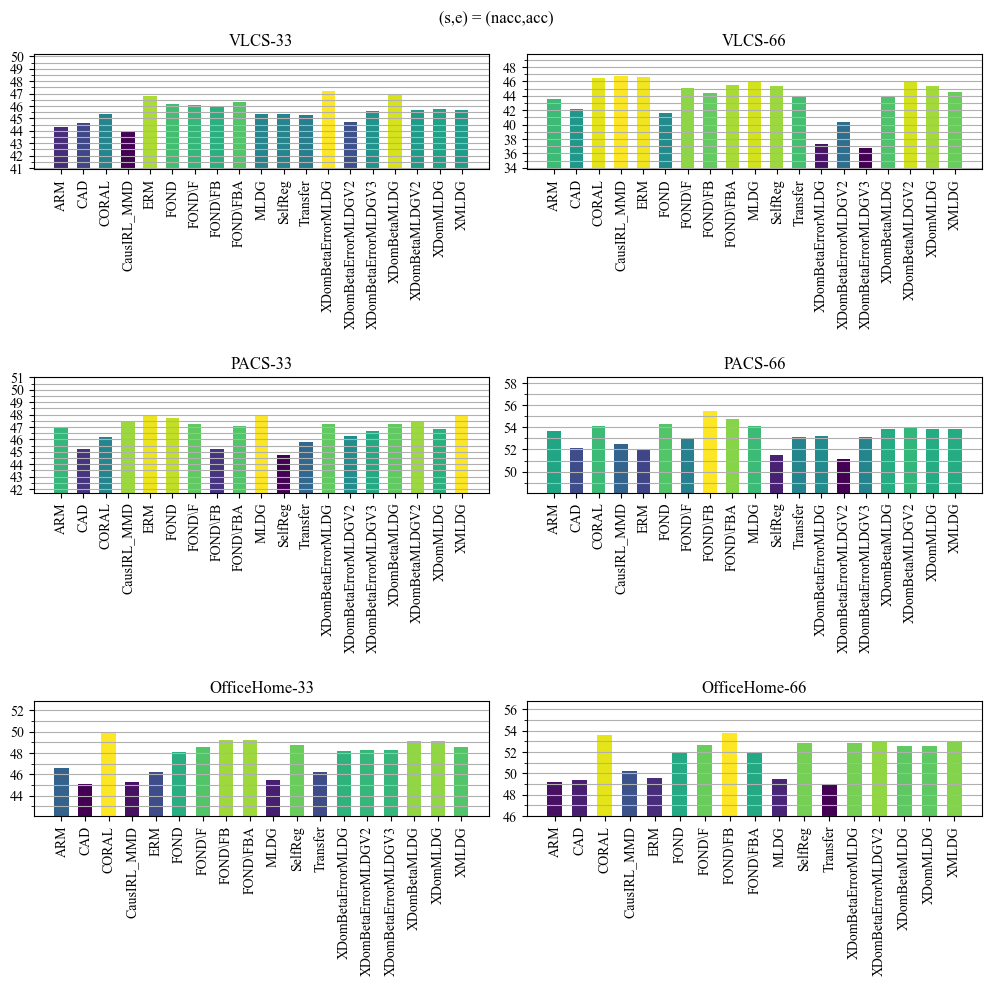

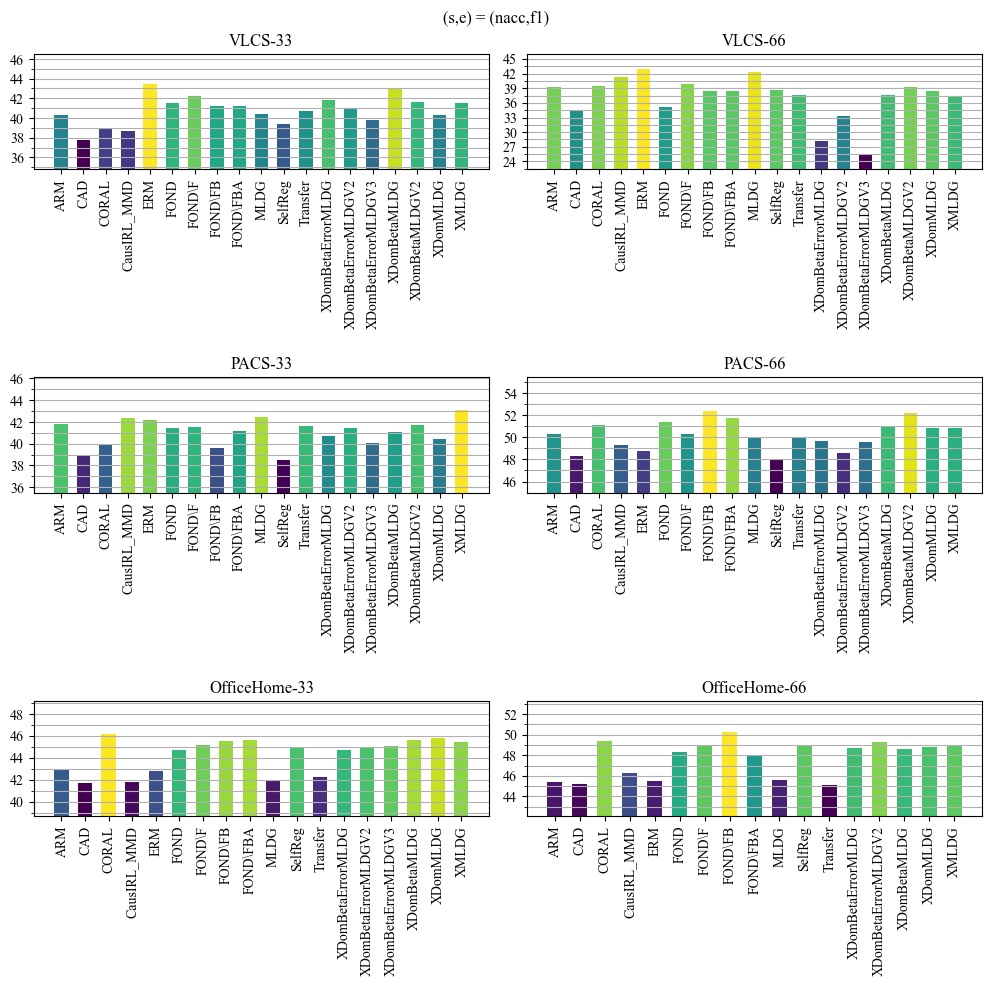

In [19]:
# remove non-baseline
data = df.loc[
    (df['algorithm'] != 'Intra') &
    (df['algorithm'] != 'SupCon') &
    (df['algorithm'] != 'Intra_XDom') &
    (df['algorithm'] != 'XDom') &
    (df['algorithm'] != 'XDomError') &
    (df['algorithm'] != 'XDomBatch') 
]

overlap_list = ['33', '66']
dataset_list = list(df["dataset"].unique())
# dataset_list = ['VLCS']
sl = list(data["selection_metric"].unique())
el = list(data["evaluation_metric"].unique())
sl_el = itertools.product(sl, el)
for s, e in sl_el:
    #if e != s: continue
    if s != 'nacc': continue
    #if e not in  ['nacc', 'vacc', 'macc']: continue
    # if e != 'f1' or s != 'f1': continue
    plot_results(data, s, e, overlap_list, dataset_list)

## Plot the relationship between "nacc" and "oacc"
- Could average across: datasets, overlaps, selection_metrics
    - Across datasets would be the most beneficial and easiest to justify
- Purpose of this plot is display the relationship between non-overlapping and overlapping class accuracies for different methods
- With `selec_metric='nacc'` across all datasets (even excluding VLCS anomally) XDom best accuracy and XDomError best non-overlapping accuracy
- Set the ylim and xlim with the zoom in plot to show the performance discrepancy
- Show the accuracy color gradient in the plot
- Use a zoomed in subplot for the results

# Global Average

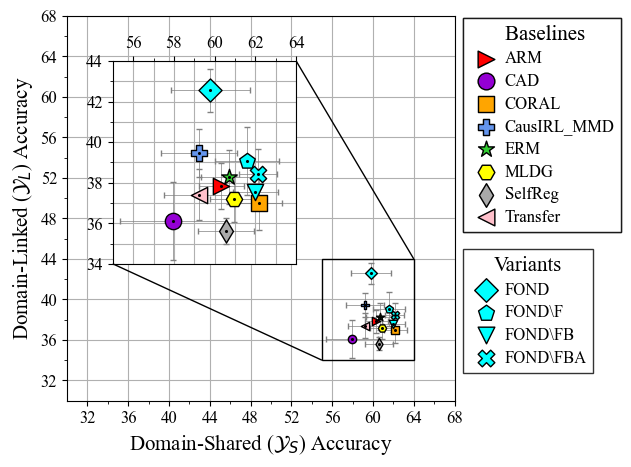

In [20]:
from results import plot_overlap_dataset, AXIS_LABELS, METHOD_NAME
import math
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

dataset_list = list(df['dataset'].unique())
x='oacc'
y='nacc'
selec_metric='nacc'
num_major_ticks = 7
offset = 5

fig, ax = plt.subplots(figsize=(5,5))

data = plot_overlap_dataset(df=df, ax=ax, selec_metric=selec_metric, x=x, y=y, markersize=2)

# AXIS LABELS
# ax.set_title(f"{dataset}-{selec_metric}")
# ax.set_title(f"")
# ax.grid(axis="both", which="both")
# SET EQUAL AXIS RANGE/VALUES
x_min = math.floor(min(data[x])) - offset
x_max = math.ceil(max(data[x])) + offset
y_min = math.floor(min(data[y])) - offset
y_max = math.ceil(max(data[y])) + offset

ax_min = y_min = x_min = min(y_min, x_min)
ax_max = y_max = x_max = max(y_max, x_max)
ax_steps = (ax_max - ax_min) / num_major_ticks

ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)

ax.set_xticks(np.arange(ax_min, ax_max, ax_steps))
ax.set_yticks(np.arange(ax_min, ax_max, ax_steps))

ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
ax.get_xaxis().set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(axis="both", which="major")

# MIRROR LINE
# ax.plot([ax_min + offset, ax_max - offset], [ax_min + offset, ax_max - offset], "k--", linewidth=1)

# LABELS
ax.set_ylabel(AXIS_LABELS[y], fontsize=15)
ax.set_xlabel(AXIS_LABELS[x], fontsize=15)
# ax.set_title("$\mathcal{Y}_O$ versus $\mathcal{Y}_N$ Accuracy Discrepancy", fontsize=15)
# LEGEND
# legend = ax.legend(
#     #loc='center left', 
#     loc='upper center',
#     bbox_to_anchor=(0.5,-0.15),
#     ncols=4,
#     columnspacing=0.2,
#     #bbox_to_anchor=(1, 0.5), 
#     title="Algorithms", 
#     markerscale=1.5, 
#     fontsize=12,
#     title_fontsize=15,
#     fancybox=False,
#     edgecolor='black',
#     handletextpad=0.4
# )
#plt.setp(legend.get_title(),fontsize=15)

# ZOOM PLOT
axins = zoomed_inset_axes(
    ax, 2, loc='upper left', bbox_to_anchor=(0.1,0.9),
                   bbox_transform=ax.transAxes)

plot_overlap_dataset(df=df, ax=axins, selec_metric=selec_metric, x=x, y=y, markersize=2.75)
axins.set_xlim(55, 64)
axins.set_ylim(34, 44)
# axins.axes.get_xaxis().set_ticklabels([])
# axins.axes.get_yaxis().set_ticklabels([])
axins.grid(axis="both", which="both")


# AXIS LABELS
# ax.set_title(f"{dataset}-{selec_metric}")
# ax.set_title(f"")
# ax.grid(axis="both", which="both")
# # SET EQUAL AXIS RANGE/VALUES
# x_min = math.floor(min(data[x])) - offset
# x_max = math.ceil(max(data[x])) + offset
# y_min = math.floor(min(data[y])) - offset
# y_max = math.ceil(max(data[y])) + offset

# ax_min = y_min = x_min = min(y_min, x_min)
# ax_max = y_max = x_max = max(y_max, x_max)
# ax_steps = (ax_max - ax_min) / num_major_ticks

# axins.set_xticks(np.arange(ax_min, ax_max, ax_steps))
# axins.set_yticks(np.arange(ax_min, ax_max, ax_steps))

axins.yaxis.set_minor_locator(AutoMinorLocator(2))
axins.xaxis.set_minor_locator(AutoMinorLocator(2))

axins.get_yaxis().set_major_locator(MaxNLocator(integer=True, nbins=5))
axins.get_xaxis().set_major_locator(MaxNLocator(integer=True, nbins=5))

axins.xaxis.set_tick_params(labeltop=True)
axins.xaxis.set_tick_params(labelbottom=False)
axins.xaxis.tick_top()
axins.tick_params(axis='both', which='major', labelsize=12)

mark_inset(ax, axins, loc1=1, loc2=3, lw=1, fc="none", ec="black", zorder=10)

# LEGEND
# LEGEND
handles, labels = ax.get_legend_handles_labels()
legend_offset = 0.03
# get baselines
baselines = ([], [])
ablations = ([], [])
for handle, label in zip(handles, labels):
    if label in BASELINES:
        baselines[0].append(handle)
        baselines[1].append(label)
    else:
        ablations[0].append(handle)
        ablations[1].append(label)

# Create a baseline class legend
# baseline_legend = fig.legend(
#     title="Baselines",
#     handles=baselines[0], 
#     labels=baselines[1], 
#     #markerscale=5,
#     loc='lower left', 
#     #ncols=len(noc_legend[0]),
#     bbox_to_anchor=(1,0.5),
#     #columnspacing=0.2,
#     title_fontsize=15,
#     #bbox_to_anchor=(1,0.65),
#     )
baseline_legend = fig.legend(
    title="    Baselines   ",
    handles=baselines[0], 
    labels=baselines[1], 
    markerscale=2,
    #markerscale=5,
    #loc='lower center', 
    #ncols=len(baselines[0]),
#     ncols=len(baselines[0])//2,
#     bbox_to_anchor=(0.515, 0.88),
    loc='lower left', 
    bbox_to_anchor=(0.9,0.43), 
    #columnspacing=0.2,
    handletextpad=0.1,
    labelspacing=0.4,
    fontsize=12,
    title_fontsize=15,
    fancybox=False,
    edgecolor='black',
    #bbox_to_anchor=(1,0.65),
    )
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(baseline_legend)

# Create the ablation class legend

# legend = fig.legend(
#     title="Ablations",
#     handles=ablations[0], 
#     labels=ablations[1], 
#     #ncols=8, 
#     loc='upper left', 
#     bbox_to_anchor=(1, 0.5), 
#     #fontsize=12, 
#     #columnspacing=0.2,
#     title_fontsize=15,
# )
legend = fig.legend(
    title="Variants",
    handles=ablations[0], 
    labels=ablations[1], 
    markerscale=2,
    #ncols=len(ablations[0])//2, 
#     loc='center left', 
#     bbox_to_anchor=(0.9,0.5),
    loc='upper left',
    #ncols=len(ablations[0]),
    bbox_to_anchor=(0.9, 0.43),
    fontsize=12, 
    columnspacing=0,
    handletextpad=0.1,
    labelspacing=0.4,
    title_fontsize=15,
    fancybox=False,
    edgecolor='black',
)
# legend = axes[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Algorithms", fontsize=12)
# plt.setp(legend.get_title(),fontsize=15)
# Save figure
fig.savefig(os.path.join(FILE_SAVE, 'average_dl_ds_plot.pdf'), bbox_inches='tight', format='pdf')

## Create a scatter plot for each dataset for each overlap
- Also visualizes the effect of different selection metrics
- Our method makes better use of more intra-domain relationships

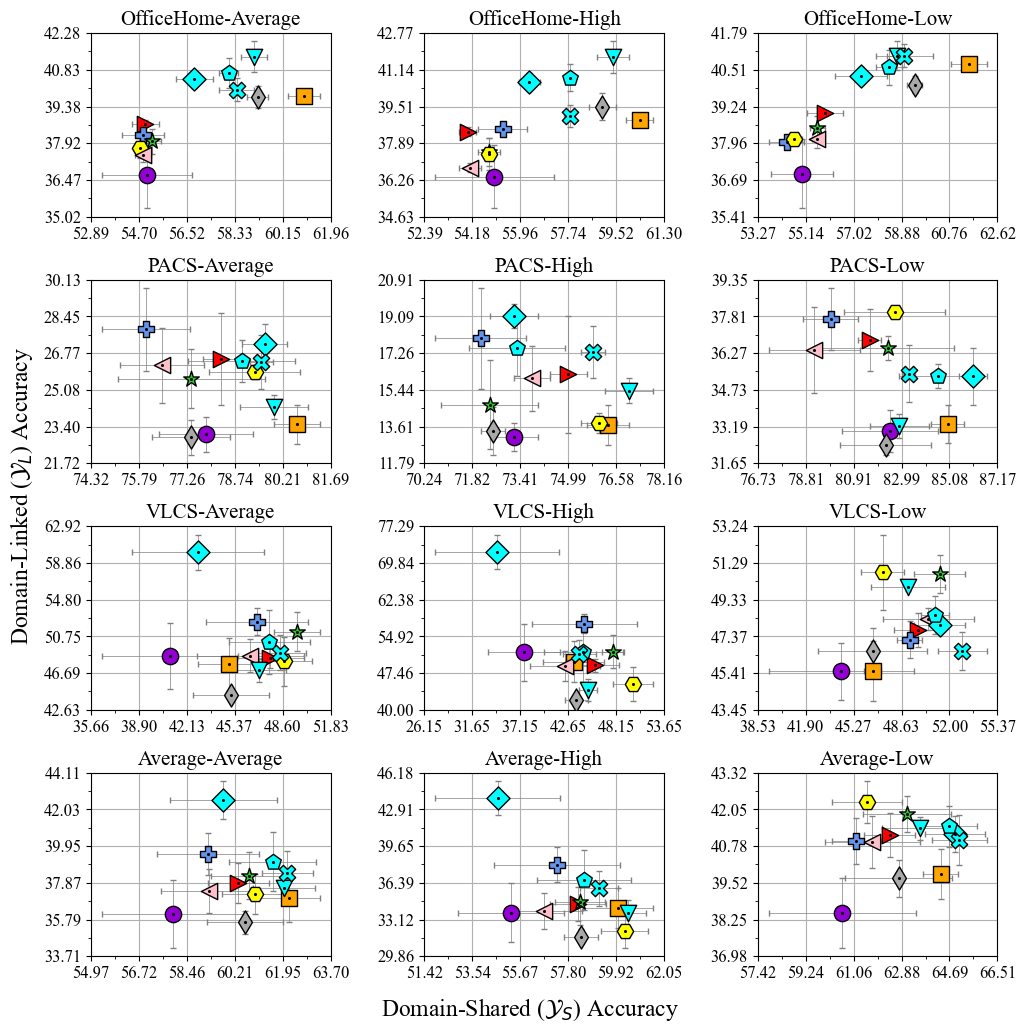

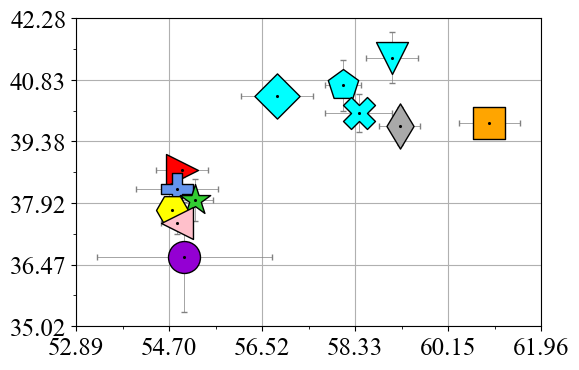

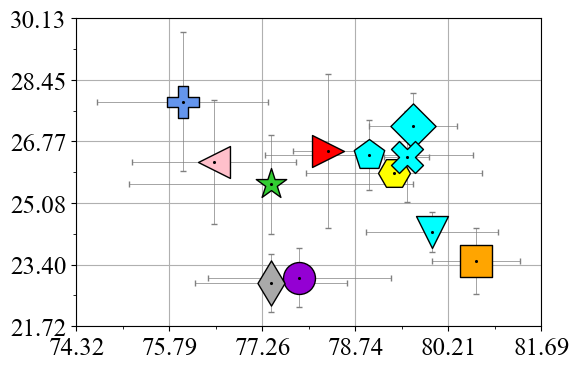

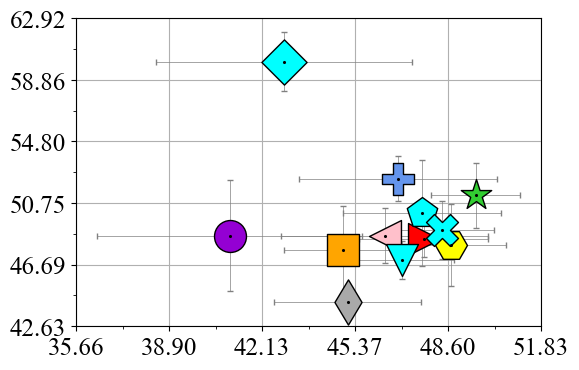

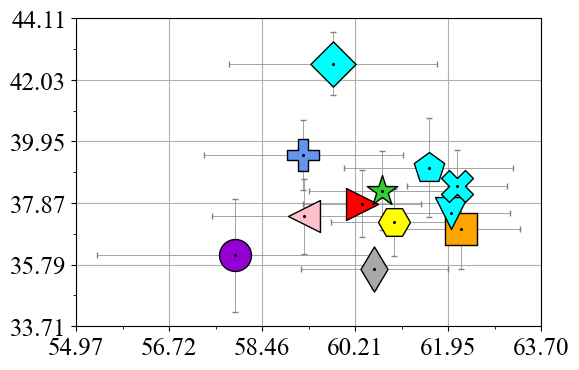

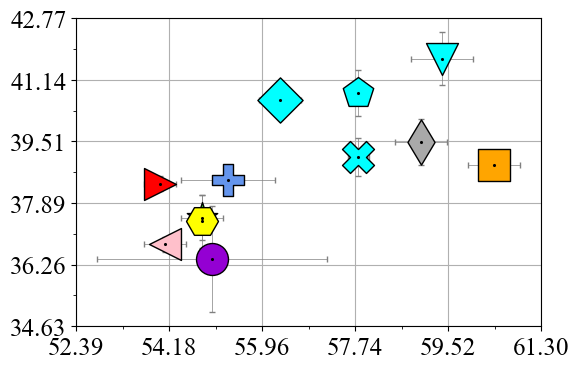

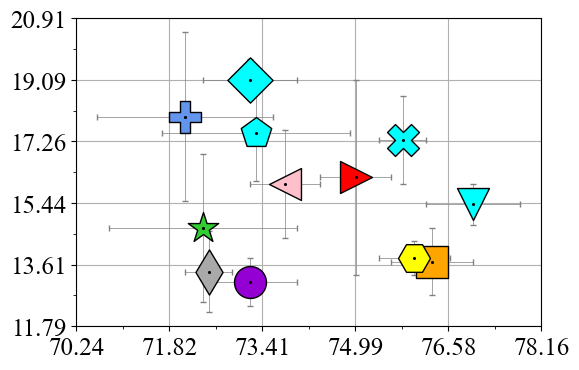

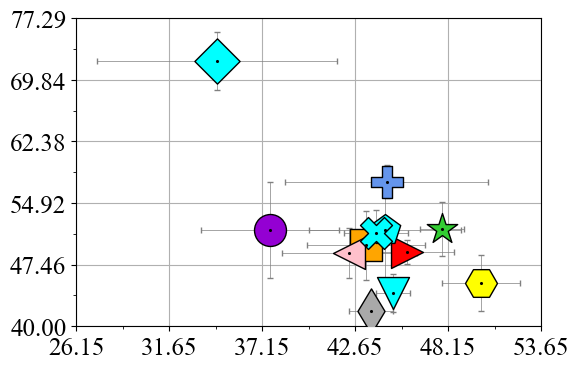

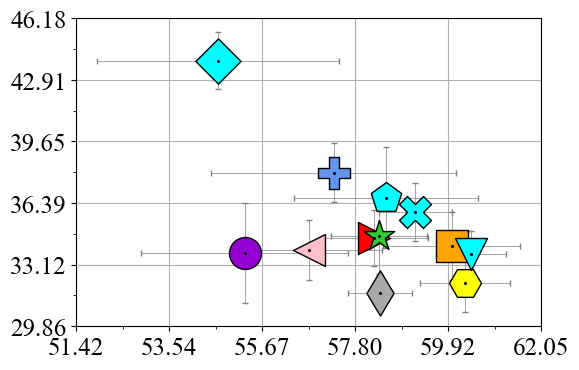

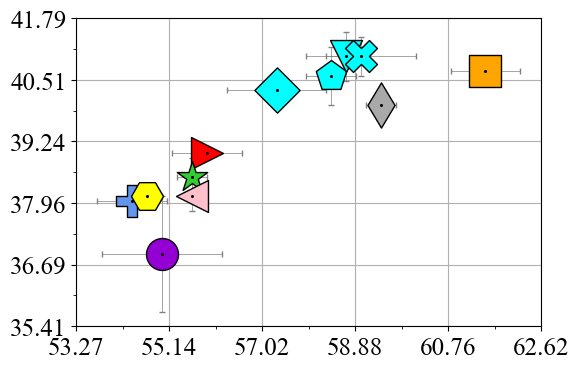

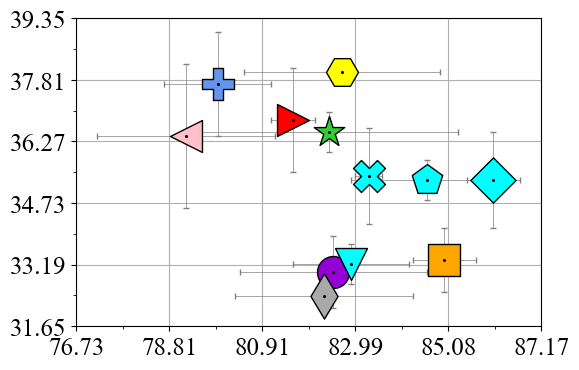

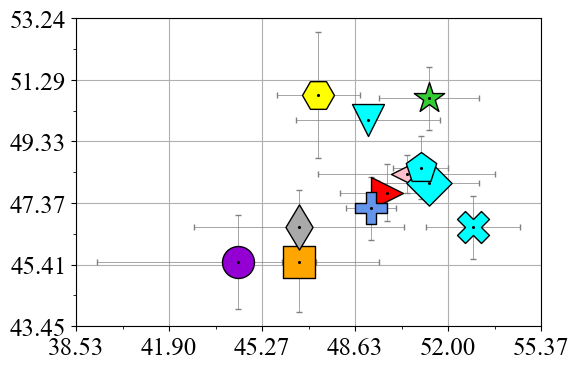

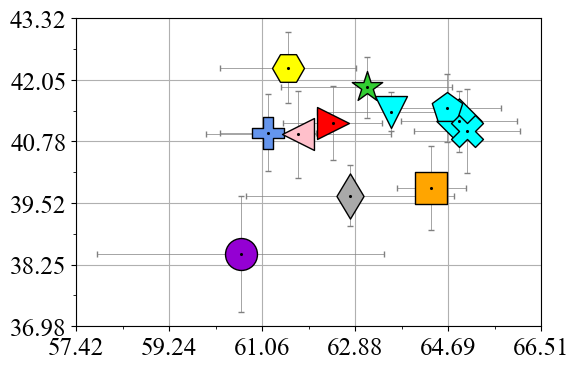

In [21]:
from results import plot_overlap_dataset, AXIS_LABELS, BASELINES
from matplotlib.ticker import AutoMinorLocator, LinearLocator, FormatStrFormatter
from matplotlib.ticker import MaxNLocator

dataset_list = list(df['dataset'].unique())
x='oacc'
y='nacc'
color_metric='acc'
selec_metric='nacc'

dataset_list = ['OfficeHome', 'PACS', 'VLCS', ['OfficeHome', 'VLCS', 'PACS']]
dataset_label = ['OfficeHome', 'PACS', 'VLCS', 'Average']
op_list = ['33', '66', ['33', '66']][::-1]
title_list = ['Low', 'High', 'Average'][::-1]

fig, axes = plt.subplots(
    nrows=len(dataset_list), 
    ncols=len(op_list), 
    figsize=(10,10), 
    #sharey='row', 
    # sharex='col',
)
for i, (overlap, op_type) in enumerate(zip(op_list, title_list)):
    for j, dataset in enumerate(dataset_list):
        ax = axes[j,i]
        data = plot_overlap_dataset(
            df=df, 
            dataset=dataset, 
            ax=ax, 
            selec_metric=selec_metric,
            x=x,
            y=y,
            color_metric=color_metric,
            overlap=overlap)

        ax.set_title(f"{dataset_label[j]}-{op_type}", fontsize=15)
        # AXIS LABELS
        # ax.set_title(f"{dataset}")
        ax.grid(axis="both", which="major")

        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))


#         ax.get_yaxis().set_major_locator(MaxNLocator(integer=True, nbins=7, min_n_ticks=7))
#         ax.get_xaxis().set_major_locator(MaxNLocator(integer=True, nbins=7, min_n_ticks=7))
        
        ax.get_yaxis().set_major_locator(LinearLocator(numticks=6))
        ax.get_xaxis().set_major_locator(LinearLocator(numticks=6))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        
        
        # We change the fontsize of major ticks label 
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # INDIVIDUAL FIGURES
        sub_fig, sub_ax = plt.subplots(figsize=(6,4))
        data = plot_overlap_dataset(
            df=df, 
            dataset=dataset, 
            ax=sub_ax, 
            selec_metric=selec_metric,
            x=x,
            y=y,
            color_metric=color_metric,
            overlap=overlap,
            markersize=3.5,
            #plot_dots=False
        )
        sub_ax.grid(axis="both", which="major")
        sub_ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        sub_ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#         sub_ax.get_yaxis().set_major_locator(MaxNLocator(integer=True, nbins=8))
#         sub_ax.get_xaxis().set_major_locator(MaxNLocator(integer=True, nbins=8))
        sub_ax.get_yaxis().set_major_locator(LinearLocator(numticks=6))
        sub_ax.get_xaxis().set_major_locator(LinearLocator(numticks=6))
        sub_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        sub_ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        sub_ax.tick_params(axis='both', which='major', labelsize=18)
        sub_fig.savefig(os.path.join(FILE_SAVE, f"{dataset_label[j].lower()}_{op_type.lower()}.pdf"), bbox_inches='tight', format='pdf')
        
#         # set average face color plot
#         if not (i != 0 and j != len(dataset_list)-1):
#             ax.set_facecolor('gainsboro')
            
#         if i == 0 and j == len(dataset_list) -1:
#             ax.set_facecolor('grey')

# AXIS LABELS
fig.text(0.5, -0.02, AXIS_LABELS[x], ha='center', fontsize=17)
fig.text(-0.02, 0.5, AXIS_LABELS[y], va='center', rotation='vertical', fontsize=17)
# https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
# axes[1][0].set_ylabel(AXIS_LABELS[y], fontsize=20)
# axes[len(op_list)-1][1].set_xlabel(AXIS_LABELS[x], fontsize=20)
# plt.ylabel(AXIS_LABELS[y], fontsize=20)
# plt.xlabel(AXIS_LABELS[x], fontsize=20)

# # LEGEND
# handles, labels = axes[0,0].get_legend_handles_labels()
# legend_offset = 0.03
# # get baselines
# baselines = ([], [])
# ablations = ([], [])
# for handle, label in zip(handles, labels):
#     if label in BASELINES:
#         baselines[0].append(handle)
#         baselines[1].append(label)
#     else:
#         ablations[0].append(handle)
#         ablations[1].append(label)

# # Create a baseline class legend
# # baseline_legend = fig.legend(
# #     title="Baselines",
# #     handles=baselines[0], 
# #     labels=baselines[1], 
# #     #markerscale=5,
# #     loc='lower left', 
# #     #ncols=len(noc_legend[0]),
# #     bbox_to_anchor=(1,0.5),
# #     #columnspacing=0.2,
# #     title_fontsize=15,
# #     #bbox_to_anchor=(1,0.65),
# #     )
# baseline_legend = fig.legend(
#     title="Baselines",
#     handles=baselines[0], 
#     labels=baselines[1], 
#     #markerscale=5,
#     loc='upper center', 
#     ncols=len(baselines[0]),
#     bbox_to_anchor=(0.5, -(0+legend_offset)),
#     #columnspacing=0.2,
#     fontsize=12,
#     title_fontsize=15,
#     fancybox=False,
#     edgecolor='black',
#     #bbox_to_anchor=(1,0.65),
#     )
# # Add the legend manually to the current Axes.
# ax = plt.gca().add_artist(baseline_legend)

# # Create the ablation class legend

# # legend = fig.legend(
# #     title="Ablations",
# #     handles=ablations[0], 
# #     labels=ablations[1], 
# #     #ncols=8, 
# #     loc='upper left', 
# #     bbox_to_anchor=(1, 0.5), 
# #     #fontsize=12, 
# #     #columnspacing=0.2,
# #     title_fontsize=15,
# # )
# legend = fig.legend(
#     title="Variants",
#     handles=ablations[0], 
#     labels=ablations[1], 
#     ncols=len(ablations[0]), 
#     loc='upper center', 
#     bbox_to_anchor=(0.5, -(0.08+legend_offset)), 
#     fontsize=12, 
#     #columnspacing=0.2,
#     title_fontsize=15,
#     fancybox=False,
#     edgecolor='black',
# )
# legend = axes[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Algorithms", fontsize=12)
# plt.setp(legend.get_title(),fontsize=15)

fig.tight_layout(pad=1.0, h_pad=1.0, w_pad=2.0)
fig.savefig(os.path.join(FILE_SAVE, 'noc_oc.pdf'), bbox_inches='tight', format='pdf')

# JUPYTER GOAL
    # Save each one of these subplots as its own separate figure as a pdf
        # fig.savefig(os.path.join(FILE_SAVE, 'total_plot_fig.pdf'), bbox_inches='tight', format='pdf')
        # keep the ticks don't plot the axis labels
        # don't plot the subplot titles 
            # these should be figure captions instead e.g. (a) OfficeHome-Average
                # I suggest make the image save name == title e.g. officehome-average.pdf
        # INTERFACE: dataset and overlap
        # SUCCESS == same plot in paper but just individual figures
# LATEX GOAL
    # Create this figure grid in latex (refer to the dataset visualization figure)
    # caption at the bottom of each subfigure which will be the title
    # LEGEND: use the large original image and crop in latex

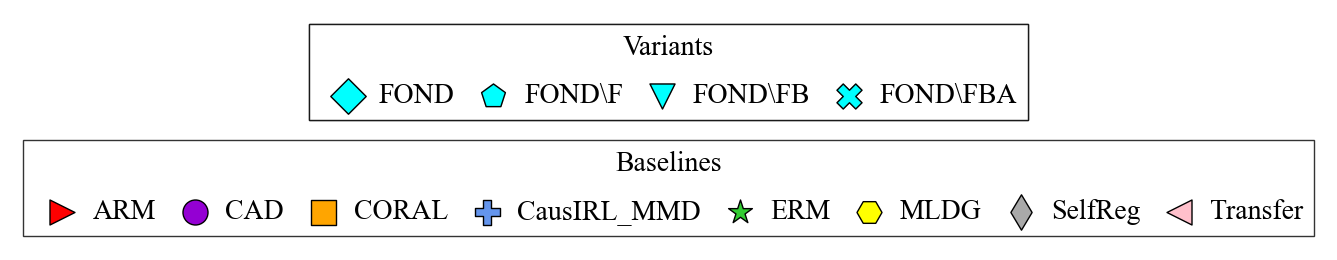

In [30]:
import matplotlib.pyplot as plt

fig_leg = plt.figure(figsize=(17, 8))
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis('off')

baseline_legend = ax_leg.legend(
    title="Baselines",
    handles=baselines[0], 
    labels=baselines[1], 
    loc='lower center', 
    ncol=len(baselines[0]),
    #bbox_to_anchor=(0.5, 1),
    fontsize=20,
    title_fontsize=20,
    fancybox=False,
    edgecolor='black',
    columnspacing=0.4,
    handletextpad=0.1,
    labelspacing=0.8,
    markerscale=3
)

variant_legend = ax_leg.legend(
    title="Variants",
    handles=ablations[0], 
    labels=ablations[1], 
    ncol=len(ablations[0]), 
    loc='upper center',
    #bbox_to_anchor=(0.5, 0.6),
    fontsize=20,
    title_fontsize=20,
    fancybox=False,
    edgecolor='black',
    columnspacing=0.4,
    handletextpad=0.1,
    labelspacing=0.8,
    markerscale=3
)

ax_leg.add_artist(baseline_legend)
ax_leg.add_artist(variant_legend)

fig_leg.subplots_adjust(bottom=0.5, top=0.8)

fig_leg.savefig(os.path.join(FILE_SAVE, 'noc_oc_legend_stacked.pdf'), bbox_inches='tight', format='pdf')

## Legend

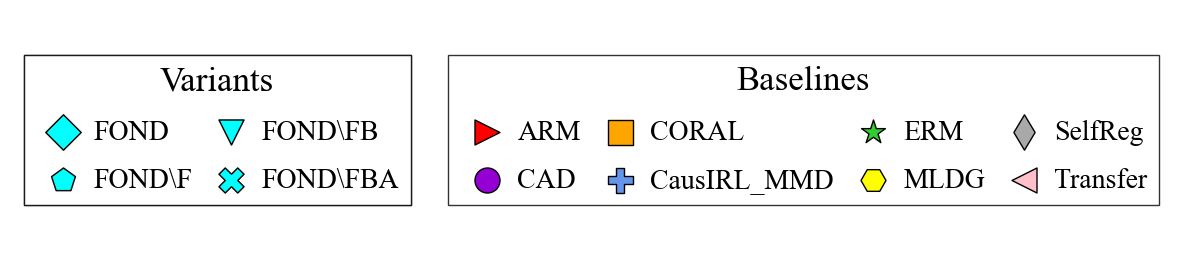

In [31]:
import matplotlib.pyplot as plt

fig_leg = plt.figure(figsize=(15, 8))
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis('off')

baseline_legend = ax_leg.legend(
    title="Baselines",
    handles=baselines[0], 
    labels=baselines[1], 
    loc='center right', 
    #ncol=len(baselines[0])//2,
    ncol=4,
    #bbox_to_anchor=(0.5, 1),
    fontsize=20,
    title_fontsize=25,
    fancybox=False,
    edgecolor='black',
    columnspacing=0.4,
    handletextpad=0.1,
    labelspacing=0.8,
    markerscale=3
)

variant_legend = ax_leg.legend(
    title="Variants",
    handles=ablations[0], 
    labels=ablations[1], 
    ncol=len(ablations[0])//2, 
    loc='center left',
    #bbox_to_anchor=(0.5, 0.6),
    fontsize=20,
    title_fontsize=25,
    fancybox=False,
    edgecolor='black',
    columnspacing=0.4,
    handletextpad=0.1,
    labelspacing=0.8,
    markerscale=3
)

ax_leg.add_artist(baseline_legend)
ax_leg.add_artist(variant_legend)

fig_leg.subplots_adjust(bottom=0.5, top=0.8)

fig_leg.savefig(os.path.join(FILE_SAVE, 'noc_oc_legend.pdf'), bbox_inches='tight', format='pdf')